### Images

The images are of **MCF-7 breast cancer cells treated for 24 h with a collection of 113 small molecules at eight concentrations**. The cells were fixed, labeled for DNA, F-actin, and Β-tubulin, and imaged by fluorescent microscopy as described [Caie et al. Molecular Cancer Therapeutics, 2010].

There are 39,600 image files (13,200 fields of view imaged in three channels) in TIFF format. We provide the images in 55 ZIP archives, one for each microtiter plate. The archives are ~750 MB each.

### Compounds

All compounds were tested at eight doses. The top concentration was different for many of the compounds and was carefully selected from the literature. Not all concentrations are available in this dataset. Missing concentrations are due to one of three factors:

- The dose was determined to be inactive. Activity was defined by setting a threshold on the Mahalanobis distance from the set of DMSO profiles: profiles of doses that were outside this threshold were considered active. The feature space corresponded to measurements extracted by a proprietary software tool used at AstraZeneca.
- The dose was determined to be overly toxic, i.e., the images had no cells or very few cells.
- The images did not pass QC, that is, they were either out of focus wells or contained image artifacts.

The highly reduced version subset of this dataset is used more commonly and termed as **Ground Truth**. `BBC021_v1_moa.csv` contains annotated mechanisms of actions of 103 compound-concentrations at 1-7 concentrations each.

- **The subset contains 2526 images which translate to 454793 single-cells.**

- **IMPA paper got 97k images after cropping around single cells**

Data Preprocessing steps used in literature:
1. Illumination Correction Algorithm

2. Crop images around single-cell instances to fixed dimension size (96 x 96) based on the cell locations.

4. *Post processing: (optional)* Typical Variation normalization (TVN) to reduce batch effects and improve profiles. It comprises of a whitening step and a correlation alignment step. 


**Data split should be leave-one-compount-out cross validation. hold out one compound (all replicates and at all concentrations)**


In [11]:
from PIL import Image
import pandas as pd
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
meta_path = "./data/bbbc021_all/metadata/bbbc021_df_all.csv"
meta_data = pd.read_csv(meta_path)
print(meta_data.shape)
meta_data.head()

(97504, 14)


,Unnamed: 0.1,Unnamed: 0,SAMPLE_KEY,BATCH,TABLE_NUMBER,IMAGE_NUMBER,OBJECT_NUMBER,CPD_NAME,SMILES,DOSE,ANNOT,STATE,PLATE,SPLIT
0,0,0,Week1_22123_1_11_3.0,Week1_22123,1,11,3.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
1,1,1,Week1_22123_1_11_5.0,Week1_22123,1,11,5.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
2,2,2,Week1_22123_1_11_6.0,Week1_22123,1,11,6.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
3,3,3,Week1_22123_1_11_7.0,Week1_22123,1,11,7.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train
4,4,4,Week1_22123_1_11_8.0,Week1_22123,1,11,8.0,cytochalasin B,C[C@@H]1CCC[C@@H](O)\\C=C\\C(=O)O[C@]23[C@@H](...,10.0,Actin disruptors,1,22123,train


In [7]:
train_meta_data = meta_data.loc[meta_data["SPLIT"] == "train"]
test_meta_data = meta_data.loc[meta_data["SPLIT"] == "test"]

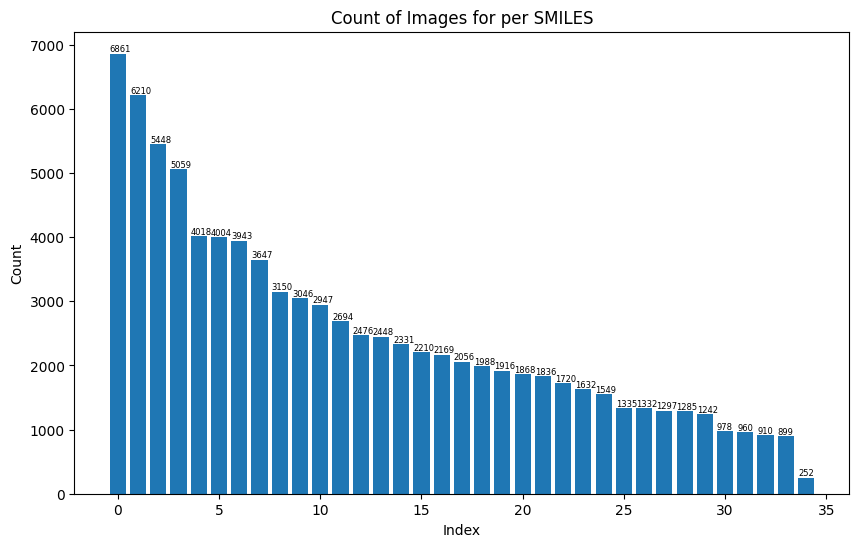

In [20]:
grouped_data = train_meta_data.groupby(by='SMILES')['SAMPLE_KEY'].size().sort_values(ascending=False).reset_index(name='count')

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(grouped_data.index, grouped_data['count'])
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Count of Images for per SMILES')

# Adding values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, int(yval), va='bottom', fontsize=6)  # va: vertical alignment

plt.show()

In [3]:
meta_data.loc[meta_data.CPD_NAME=='DMSO']['DOSE'].value_counts()

0.0    6900
Name: DOSE, dtype: int64

In [26]:
from tabulate import tabulate

# Assuming meta_data is already defined
dose_counts = meta_data.DOSE.value_counts().reset_index()
dose_counts.columns = ['DOSE', 'Count']

# Pretty print the table
print(tabulate(dose_counts, headers='keys', tablefmt='pretty'))

+----+-------+---------+
|    | DOSE  |  Count  |
+----+-------+---------+
| 0  |  1.0  | 17056.0 |
| 1  |  3.0  | 14897.0 |
| 2  |  0.3  | 14672.0 |
| 3  | 10.0  | 12734.0 |
| 4  |  0.1  | 11563.0 |
| 5  |  0.0  | 6900.0  |
| 6  | 0.03  | 5858.0  |
| 7  | 0.003 | 2517.0  |
| 8  | 0.01  | 2166.0  |
| 9  |  5.0  | 1948.0  |
| 10 | 30.0  | 1332.0  |
| 11 |  1.5  | 1248.0  |
| 12 | 15.0  | 1163.0  |
| 13 |  2.0  | 1046.0  |
| 14 | 50.0  |  804.0  |
| 15 |  6.0  |  711.0  |
| 16 | 20.0  |  454.0  |
| 17 | 100.0 |  435.0  |
+----+-------+---------+


In [6]:
meta_data.groupby(['SMILES', 'DOSE']).size()

SMILES                                                                                                                                                           DOSE 
CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)[C@@H]2[C@H](OC(=O)c4ccccc4)[C@]5(O)C[C@H](OC(=O)[C@H](O)[C@@H](NC(=O)OC(C)(C)C)c6ccccc6)C(=C([C@@H](O)C3=O)C5(C)C)C     0.03      788
                                                                                                                                                                 0.10      669
                                                                                                                                                                 0.30      673
CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C@@]3(OC(=O)C)[C@H]2[C@H](OC(=O)c4ccccc4)[C@]5(O)C[C@H](OC(=O)[C@H](O)[C@@H](NC(=O)c6ccccc6)c7ccccc7)C(=C1C5(C)C)C  0.30      358
                                                                                                                                     

In [28]:
meta_data.groupby(by='SMILES')['SAMPLE_KEY'].size().reset_index(name='count')

,SMILES,count
0,CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)[C@@H]...,2130
1,CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C...,1382
2,CC(C)(C)n1nc(c2ccc(Cl)cc2)c3c(N)ncnc13,1484
3,CC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(...,1012
4,CC(C)[C@H](O)C1(NC(=O)[C@H](C)[C@@H]1O)C(=O)SC...,1087
5,CC1CC(C)C(=O)C(C1)C(O)CC2CC(=O)NC(=O)C2,2752
6,CCC(C)(C)C(=O)O[C@H]1C[C@@H](C)C=C2C=C[C@H](C)...,2211
7,CCC(C)C(NC(=O)OCc1ccccc1)C(=O)NC(CCC(=O)OC(C)(...,2285
8,CCC1CN2CCc3cc(OC)c(OC)cc3C2CC1CC4NCCc5cc(OC)c(...,3385
9,CCCCC(NC(=O)[C@H](CC(C)C)NC(=O)[C@H](CC(C)C)NC...,1429


In [29]:
meta_data.groupby(by=['SMILES', 'SPLIT'])['SAMPLE_KEY'].size().reset_index(name='count')

,SMILES,SPLIT,count
0,CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)[C@@H]...,test,214
1,CC(=O)O[C@@]12CO[C@@H]1C[C@H](O)[C@]3(C)[C@@H]...,train,1916
2,CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C...,test,140
3,CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C...,train,1242
4,CC(C)(C)n1nc(c2ccc(Cl)cc2)c3c(N)ncnc13,test,149
...,...,...,...
65,OCCNCCNc1ccc(NCCNCCO)c2C(=O)c3c(O)ccc(O)c3C(=O...,train,1332
66,[O-][N+](=O)c1ccc(cc1)c2nc(c3ccc(F)cc3)c([nH]2...,test,448
67,[O-][N+](=O)c1ccc(cc1)c2nc(c3ccc(F)cc3)c([nH]2...,train,4018
68,[O-][N+](=O)c1ccc2[nH]c3c(CC(=O)Nc4ccccc34)c2c1,test,439


In [ ]:
# all SMILES are both in train and test splits - We don't want this
# We want to split the data based on SMILES because we need to test on out of distributinon dataset
# DMSO has only one dose (0.0) - we don't need to use DMSO for training, or do we?
# We can use DMSO for training, and testing both but not other SMILES
# c'mon man, how do we split the dataset? Do we split it on SMILES or not? 
# We do need some out of distribution drugs.
# how about not split on SMILES, just use the 'SPLIT' columnn as menttioned in the dataset
# and use SMILES from some other dataset for to be used for out of distribution testing?
# It seems more reasonable?

In [13]:
import pickle
with open("./data/bbbc021_all/unique_smiles_morgan_fingerprints.pkl", "rb") as f:
    unique_morgan_fingerprints = pickle.load(f)

In [15]:
type(unique_morgan_fingerprints)

dict

In [6]:
file_path = os.path.join("data", "BBBC021", "BBBC021_v1_moa.csv")
image_metadata_path = os.path.join("data", "BBBC021", "BBBC021_v1_image.csv")
compound_metadata_path = os.path.join("data", "BBBC021", "BBBC021_v1_compound.csv")
metadata = pd.read_csv(file_path)
print(metadata.shape)
metadata.head()

(104, 3)


,compound,concentration,moa
0,PP-2,3.0,Epithelial
1,emetine,0.3,Protein synthesis
2,AZ258,1.0,Aurora kinase inhibitors
3,cytochalasin B,10.0,Actin disruptors
4,ALLN,3.0,Protein degradation


In [7]:
compound_data = pd.read_csv(compound_metadata_path)
print(compound_data.shape)
compound_data.head()

(113, 2)


,compound,smiles
0,DMSO,NaN
1,leupeptin,CC(C)C[C@H](NC(=O)C)C(=O)N[C@@H](CC(C)C)C(=O)N...
2,taxol,CC(=O)O[C@H]1C(=O)[C@]2(C)[C@@H](O)C[C@H]3OC[C...
3,camptothecin,CC[C@@]1(O)C(=O)OCC2=C1C=C3N(Cc4cc5ccccc5nc34)...
4,Cdk1 inhibitor III,CCOC(=O)c1cnc2oc3ccc(O)cc3c2c1c4ccccc4


In [21]:
compound_data.loc[compound_data["compound"] == "5-fluorouracil"]

,compound,smiles
30,5-fluorouracil,FC1=CNC(=O)NC1=O


In [8]:
images_data = pd.read_csv(image_metadata_path)
print(images_data.shape)
images_data.head()

(13200, 13)


,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration
0,4,233,G10_s1_w1BEDC2073-A983-4B98-95E9-84466707A25D.tif,Week4/Week4_27481,G10_s1_w2DCEC82F3-05F7-4F2F-B779-C5DF9698141E.tif,Week4/Week4_27481,G10_s1_w43CD51CBC-2370-471F-BA01-EE250B14B3C8.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
1,4,234,G10_s2_w11C3B9BCC-E48F-4C2F-9D31-8F46D8B5B972.tif,Week4/Week4_27481,G10_s2_w2570437EF-C8DC-4074-8D63-7FA3A7271FEE.tif,Week4/Week4_27481,G10_s2_w400B21F33-BDAB-4363-92C2-F4FB7545F08C.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
2,4,235,G10_s3_w1F4FCE330-C71C-4CA3-9815-EAF9B9876EB5.tif,Week4/Week4_27481,G10_s3_w2194A9AC7-369B-4D84-99C0-DA809B0042B8.tif,Week4/Week4_27481,G10_s3_w4E0452054-9FC1-41AB-8C5B-D0ACD058991F.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
3,4,236,G10_s4_w1747818B4-FFA7-40EE-B0A0-6A5974AF2644.tif,Week4/Week4_27481,G10_s4_w298D4652F-B5BF-49F2-BE51-8149DF83EAFD.tif,Week4/Week4_27481,G10_s4_w42648D36D-6B77-41CD-B520-6E4C533D9ABC.tif,Week4/Week4_27481,Week4_27481,G10,1,5-fluorouracil,0.003
4,4,473,G10_s1_w10034568D-CC12-43C3-93A9-DC3782099DD3.tif,Week4/Week4_27521,G10_s1_w2A29ED14B-952C-4BA1-89B9-4F92B6DADEB4.tif,Week4/Week4_27521,G10_s1_w4DAA2E9D1-F6E9-45FA-ADC0-D341B647A680.tif,Week4/Week4_27521,Week4_27521,G10,2,5-fluorouracil,0.003


In [10]:
images_data.Replicate.value_counts(0)

1    4560
2    4320
3    4320
Name: Replicate, dtype: int64

In [20]:
images_data.loc[images_data["Image_Metadata_Compound"] == "leupeptin"]

,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration
4268,8,33,Week8_4sites_B10_s1_w1D5CBC2D1-ACB1-433C-977A-...,Week8/Week8_38203,Week8_4sites_B10_s1_w2C230640C-A8D5-4339-946B-...,Week8/Week8_38203,Week8_4sites_B10_s1_w4DB7BF1CF-8A3B-455D-A73A-...,Week8/Week8_38203,Week8_38203,B10,1,leupeptin,0.006
4269,8,34,Week8_4sites_B10_s2_w13F14F5F9-B4F1-49B8-965D-...,Week8/Week8_38203,Week8_4sites_B10_s2_w26F006853-2632-4F49-A9D9-...,Week8/Week8_38203,Week8_4sites_B10_s2_w4C6494279-89D4-4291-9CE3-...,Week8/Week8_38203,Week8_38203,B10,1,leupeptin,0.006
4270,8,35,Week8_4sites_B10_s3_w1154712F2-D261-4016-8E52-...,Week8/Week8_38203,Week8_4sites_B10_s3_w2F00732DA-17AF-4841-B4F8-...,Week8/Week8_38203,Week8_4sites_B10_s3_w4D6FD32CC-9A7E-4F4E-9322-...,Week8/Week8_38203,Week8_38203,B10,1,leupeptin,0.006
4271,8,36,Week8_4sites_B10_s4_w18919E08C-E193-4472-AB52-...,Week8/Week8_38203,Week8_4sites_B10_s4_w2875C187B-2A76-41F6-A7B6-...,Week8/Week8_38203,Week8_4sites_B10_s4_w4A809D0AA-0D73-4A4F-AF6A-...,Week8/Week8_38203,Week8_38203,B10,1,leupeptin,0.006
4272,8,273,Week8_4sites_B10_s1_w1310AE044-F5D2-4C3D-9191-...,Week8/Week8_38221,Week8_4sites_B10_s1_w24C4E1171-1E9A-4CAE-A900-...,Week8/Week8_38221,Week8_4sites_B10_s1_w42C79CF9A-1F96-4BF4-A730-...,Week8/Week8_38221,Week8_38221,B10,2,leupeptin,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4359,8,248,Week8_4sites_B03_s4_w122CB0442-41E2-4385-94DA-...,Week8/Week8_38221,Week8_4sites_B03_s4_w2087BD89A-A5AD-45EC-91EC-...,Week8/Week8_38221,Week8_4sites_B03_s4_w42286FAEE-46EE-4578-BD34-...,Week8/Week8_38221,Week8_38221,B03,2,leupeptin,20.000
4360,8,485,Week8_4sites_B03_s1_w176F3BF20-773B-4A4A-A3AF-...,Week8/Week8_38241,Week8_4sites_B03_s1_w271260759-B5BA-476C-839A-...,Week8/Week8_38241,Week8_4sites_B03_s1_w42E02DF9C-1932-4BC3-B3AA-...,Week8/Week8_38241,Week8_38241,B03,3,leupeptin,20.000
4361,8,486,Week8_4sites_B03_s2_w18D2C62B7-634A-476D-907D-...,Week8/Week8_38241,Week8_4sites_B03_s2_w2BDFB7B06-6FBB-47C8-9C49-...,Week8/Week8_38241,Week8_4sites_B03_s2_w4BB054F93-5916-462D-B25B-...,Week8/Week8_38241,Week8_38241,B03,3,leupeptin,20.000
4362,8,487,Week8_4sites_B03_s3_w1ED09A04D-0548-4589-A66F-...,Week8/Week8_38241,Week8_4sites_B03_s3_w2DBEC4114-C4D0-4551-8948-...,Week8/Week8_38241,Week8_4sites_B03_s3_w4EDC90A73-AE7B-48E6-9E8F-...,Week8/Week8_38241,Week8_38241,B03,3,leupeptin,20.000
